In [48]:
from bs4 import BeautifulSoup
import requests
import re
import seaborn as sns
import pandas as pd
import numpy as np
import os
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import json
import urllib.request
from sklearn.metrics import r2_score
# from sklearn.model_selection import TimeSeriesSplit

In [5]:
# class YoutubeChannel():
#     def __init__(self,ChannelUrl):
#         self.dailySubscribers = allData[["Date","DailySubscribers"]]
#         self.totalSubscribers = allData[["Date","TotalSubscribers"]]
#         self.dailyVideoViews = allData[["Date","DailyVideoViews"]]
#         self.totalVideoViews = allData[["Date","TotalVideoViews"]]
#         self.allData = getAllCharts()

In [6]:
links = ["https://web.archive.org/web/20190524171902/https://socialblade.com/youtube/user/mmoshaya/monthly",
        "https://web.archive.org/web/20190524075036/https://socialblade.com/youtube/user/arabgamesnetwork/monthly",
         "https://web.archive.org/web/20190830014628/https://socialblade.com/youtube/channel/UCBzrJ1zGf9-0cd5-n7sBraQ/monthly",
        "https://web.archive.org/web/20190524134324/https://socialblade.com/youtube/channel/UCqJNTGwKmgMCwfYDbnz514Q/monthly",
        "https://web.archive.org/web/20190525094206/https://socialblade.com/youtube/user/banderitax/monthly",
        "https://web.archive.org/web/20190830022605/https://socialblade.com/youtube/channel/UCPvLEc3la6Q2MdlCXzKRRPg/monthly"]

In [7]:
# save req to html file if not found
for i in range(len(links)):
    if f"req{i}.html" not in os.listdir('.'):
        open("req"+str(i)+".html","w",encoding="UTF-8").write(requests.get(links[i]).text)

In [8]:
# read files from  disk - files name: req0.html .... req4.html
resText = [open("req"+str(i)+".html","r",encoding="UTF-8").read() for i in range(len(links))]

In [9]:
def getChartData(soup,chart_name):
    ds_element = soup.find("div",{"id":chart_name}).next_element.next_element.text
    regex = "[0-9]+-[0-9]+-[0-9]+,[0-9]+"
    dailySub = [i.split(",") for i in re.findall(regex,ds_element)]
    Date = pd.Series([i[0] for i in dailySub])
    count = pd.Series([i[1] for i in dailySub])
    return pd.DataFrame({
        "Date":Date.astype(np.datetime64),
        chart_name:count.astype(np.int64)
        })

In [10]:
def getDailySubscribers(soup):
    '''
    return dataframe contains date and dailySubscribers for the given soup
    '''
    return getChartData(soup,"DailySubscribers")

In [11]:
def getTotalSubscribers(soup):
    '''
    return dataframe contains date and totalSubscribers for the given soup
    '''
    return getChartData(soup,"TotalSubscribers")

In [12]:
def getDailyVideoViews(soup):
    '''
    return dataframe contains date and dailyVideoViews for the given soup
    '''
    return getChartData(soup,"DailyVideoViews")

In [13]:
def getTotalVideoViews(soup):
    '''
    return dataframe contains date and totalVideoViews for the given soup
    '''
    return getChartData(soup,"TotalVideoViews")

In [14]:
def getAllCharts(soup):
    '''
    return dataframe contains date, dailySubscribers, totalSubscribers, dailyVideoViews and totalVideoViews for the given soup
    '''
    ds = getDailySubscribers(soup)
    ts = getTotalSubscribers(soup)
    dv = getDailyVideoViews(soup)
    tv = getTotalVideoViews(soup)
    return ds.merge(ts,on="Date").merge(dv,on="Date").merge(tv,on="Date")

In [15]:
soups = [BeautifulSoup(r,"html5lib") for r in resText]

In [16]:
channels_df = [getAllCharts(soup) for soup in soups]

In [17]:
top1_df = channels_df[0] # top 1 channel df
top2_df = channels_df[1] # top 2 channel df
top3_df = channels_df[2] # top 3 channel df
# top4_df = channels_df[3] # top 4 channel df شلناها لان عدد الروز قليل
top4_df = channels_df[4] # top 4 channel df
top5_df = channels_df[5] # top 4 channel df

In [18]:
X_y = top1_df[["Date","TotalSubscribers"]]#[top1_df["DailyVideoViews"] != 0]
X_y.columns = ["ds","y"]
m = Prophet(daily_seasonality=True)
m.fit(X_y)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [19]:
future = m.make_future_dataframe(periods=365)

In [20]:
forecast = m.predict(future)

In [21]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1446,2020-05-18,1.792334e+07,1.542189e+07,2.025112e+07
1447,2020-05-19,1.794252e+07,1.544087e+07,2.029087e+07
1448,2020-05-20,1.796168e+07,1.545568e+07,2.031264e+07
1449,2020-05-21,1.798074e+07,1.546909e+07,2.033297e+07
1450,2020-05-22,1.800025e+07,1.547928e+07,2.037242e+07


In [22]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1446,2020-05-18,1.792334e+07,1.542189e+07,2.025112e+07
1447,2020-05-19,1.794252e+07,1.544087e+07,2.029087e+07
1448,2020-05-20,1.796168e+07,1.545568e+07,2.031264e+07
1449,2020-05-21,1.798074e+07,1.546909e+07,2.033297e+07
1450,2020-05-22,1.800025e+07,1.547928e+07,2.037242e+07


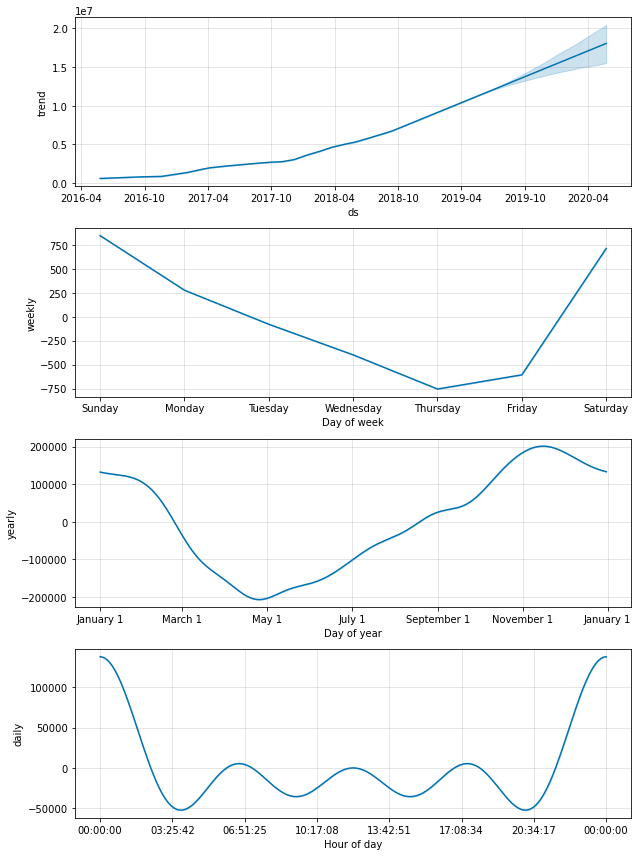

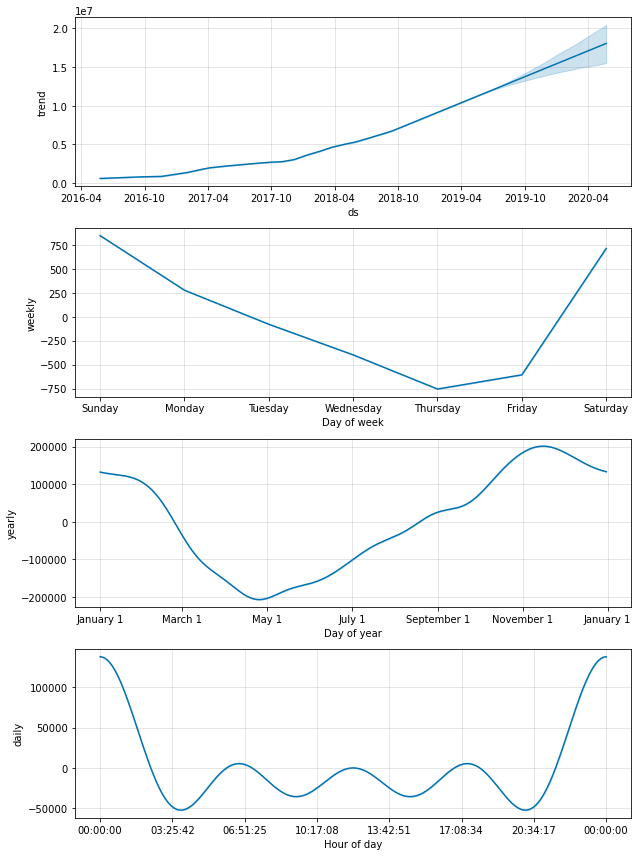

In [23]:
 m.plot_components(forecast)

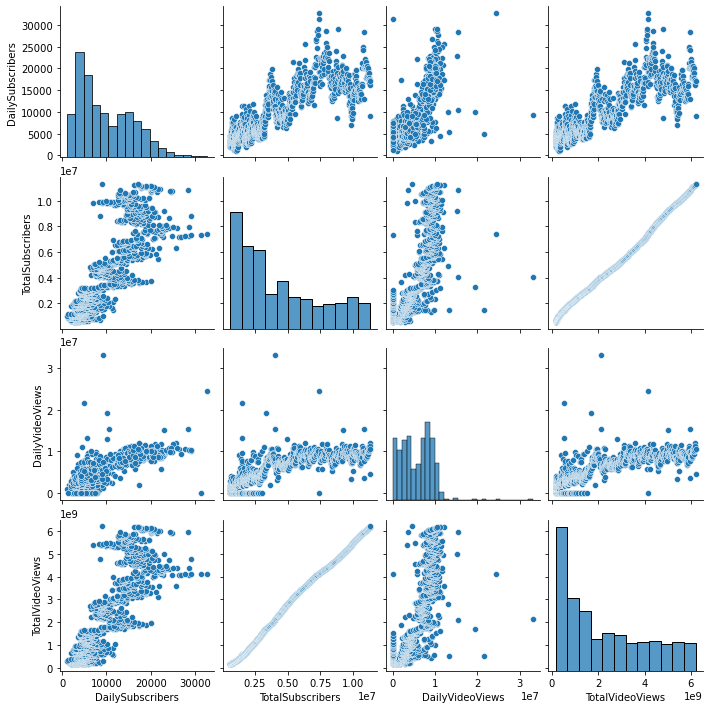

In [24]:
sns.pairplot(top1_df)

In [25]:
# total number of rows
# total = 0
# for c in [top1_df,top2_df,top3_df,top4_df,top5_df]:
#     total += len(c)
# print(f"the total number of rows is {total}")

In [26]:
# for c in [top1_df,top2_df,top3_df,top4_df,top5_df]:
#     print(c.info())

In [31]:
def getAllCharts_newlinks(url):
    opener = urllib.request.build_opener()
    opener.addheaders = [('User-agent', 'Mozilla/5.0')]
    response = str(opener.open(url).read())
    allCharts = [json.loads(l[0]) for l in re.findall('(\[(\[\d+,\d+\],?)+\])',response)]
    col = re.findall('title: { text: \\\\\'([\w|\s]+) for',response)
    date1 = pd.Series([i[0] for i in allCharts[0]])
    weeklyGainedSubsAndViews = pd.DataFrame({
        "Date": pd.to_datetime(date1,unit="ms"),#.dt.date, #parse Date from timestamp to date
        col[0]: [i[1] for i in allCharts[0]],
        col[1]: [i[1] for i in allCharts[1]],
    })

    date2 = pd.Series([i[0] for i in allCharts[2]])
    monthlyTotoalSubsAndViews = pd.DataFrame({
        "Date": pd.to_datetime(date2,unit="ms"),#.dt.date, #parse Date from timestamp to date
        "TotalSubscribers": [i[1] for i in allCharts[2]],
        "TotalVideoViews": [i[1] for i in allCharts[3]],
    })

    date3 = pd.Series([i[0] for i in allCharts[4]])
    weeklyTotoalSubsAndViews = pd.DataFrame({
        "Date": pd.to_datetime(date3,unit="ms"),#.dt.date, #parse Date from timestamp to date
        "TotalSubscribers": [i[1] for i in allCharts[4]],
        "TotalVideoViews": [i[1] for i in allCharts[5]],
    })
    return [weeklyGainedSubsAndViews,monthlyTotoalSubsAndViews,weeklyTotoalSubsAndViews]

In [32]:
top1 = getAllCharts_newlinks("https://socialblade.com/youtube/user/mmoshaya/monthly")

In [70]:
top1_m = pd.concat([top1_df[["Date","TotalSubscribers","TotalVideoViews"]],top1[1],top1[2]]).sort_values(by="Date",ignore_index=True)

In [71]:
X_y = top1_m[["Date","TotalVideoViews"]]#[top1_df["DailyVideoViews"] != 0]
X_y.columns = ["ds","y"]

In [72]:
# tss = TimeSeriesSplit()
# for tarin,val in tss.split(X_y):
md = Prophet()
md.fit(X_y)

In [91]:
# for train,val in kf:
#     print("train Range:",min(train),max(train),"val Range:",min(val),max(val))
X_y.ds

0      2016-05-26 00:00:00
1      2016-05-27 00:00:00
2      2016-05-28 00:00:00
3      2016-05-29 00:00:00
4      2016-05-30 00:00:00
               ...        
1167   2021-08-21 04:00:00
1168   2021-08-29 04:00:00
1169   2021-09-06 04:00:00
1170   2021-09-14 04:00:00
1171   2021-09-21 04:00:00
Name: ds, Length: 1172, dtype: datetime64[ns]

In [86]:
df_cv = cross_validation(md,initial='730 days', period='180 days', horizon = '365 days')

INFO:prophet:Making 5 forecasts with cutoffs between 2018-10-02 04:00:00 and 2020-09-21 04:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

In [90]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-10-03 00:00:00,4.110883e+09,4.105405e+09,4.116123e+09,4114035251,2018-10-02 04:00:00
1,2018-10-04 00:00:00,4.120368e+09,4.114928e+09,4.126248e+09,4124031720,2018-10-02 04:00:00
2,2018-10-05 00:00:00,4.129806e+09,4.124545e+09,4.135076e+09,4129869850,2018-10-02 04:00:00
3,2018-10-06 00:00:00,4.139567e+09,4.133748e+09,4.145159e+09,4129869850,2018-10-02 04:00:00
4,2018-10-07 00:00:00,4.149134e+09,4.143430e+09,4.154888e+09,4154372615,2018-10-02 04:00:00
...,...,...,...,...,...,...
418,2021-08-21 04:00:00,1.398352e+10,1.324061e+10,1.466343e+10,14316702181,2020-09-21 04:00:00
419,2021-08-29 04:00:00,1.406052e+10,1.329986e+10,1.476748e+10,14373671876,2020-09-21 04:00:00
420,2021-09-06 04:00:00,1.413192e+10,1.334966e+10,1.488113e+10,14431542398,2020-09-21 04:00:00
421,2021-09-14 04:00:00,1.419330e+10,1.337812e+10,1.495796e+10,14485936904,2020-09-21 04:00:00


In [89]:
r2_score(df_cv.y,df_cv.yhat)

0.9955516550430941

In [88]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,17 days 20:00:00,1.352118e+15,3.677115e+07,1.468324e+07,0.001773,0.000688,0.001777,0.714286
1,18 days 20:00:00,1.357284e+15,3.684133e+07,1.505200e+07,0.001847,0.000872,0.001851,0.666667
2,19 days 20:00:00,1.362413e+15,3.691088e+07,1.538882e+07,0.001919,0.000946,0.001923,0.619048
3,20 days 20:00:00,1.368415e+15,3.699209e+07,1.583252e+07,0.002010,0.001105,0.002014,0.571429
4,21 days 20:00:00,1.373625e+15,3.706245e+07,1.621030e+07,0.002087,0.001197,0.002090,0.535714
...,...,...,...,...,...,...,...,...
328,354 days 01:00:00,1.389522e+17,3.727629e+08,3.304187e+08,0.026457,0.029688,0.026897,0.976190
329,358 days 00:00:00,1.306186e+17,3.614120e+08,3.181413e+08,0.025467,0.027195,0.025879,1.000000
330,362 days 00:00:00,1.313164e+17,3.623760e+08,3.188645e+08,0.025584,0.027195,0.026001,1.000000
331,364 days 00:00:00,1.313089e+17,3.623657e+08,3.188358e+08,0.025529,0.027195,0.025944,1.000000


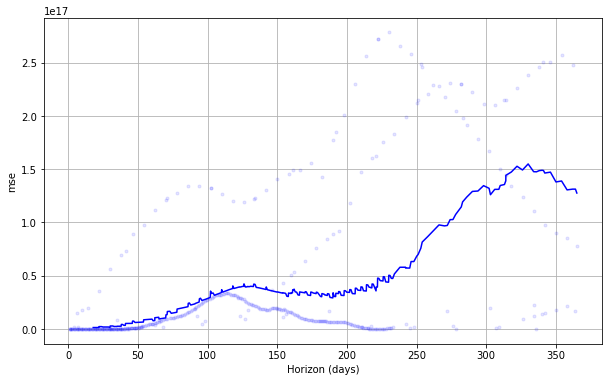

In [98]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mse')

In [88]:
future = md.make_future_dataframe(periods=365)

In [89]:
future

,ds
0,2016-05-26 00:00:00
1,2016-05-27 00:00:00
2,2016-05-28 00:00:00
3,2016-05-29 00:00:00
4,2016-05-30 00:00:00
...,...
1530,2022-09-16 04:00:00
1531,2022-09-17 04:00:00
1532,2022-09-18 04:00:00
1533,2022-09-19 04:00:00


In [90]:
forecast = md.predict(future)

In [91]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1530,2022-09-16 04:00:00,1.816333e+10,1.755824e+10,1.883464e+10
1531,2022-09-17 04:00:00,1.817382e+10,1.755894e+10,1.885438e+10
1532,2022-09-18 04:00:00,1.818173e+10,1.755353e+10,1.884076e+10
1533,2022-09-19 04:00:00,1.819237e+10,1.758504e+10,1.887195e+10
1534,2022-09-20 04:00:00,1.820486e+10,1.758346e+10,1.888672e+10


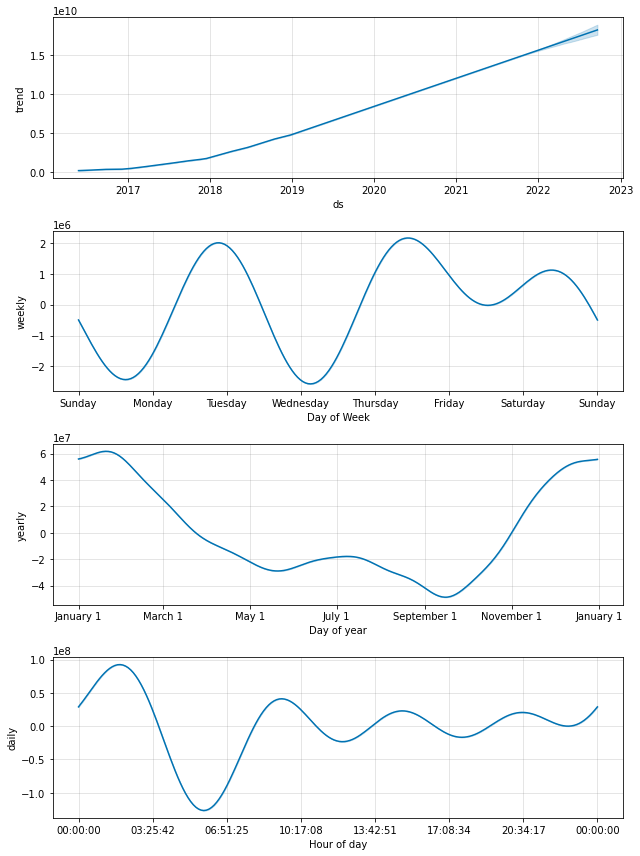

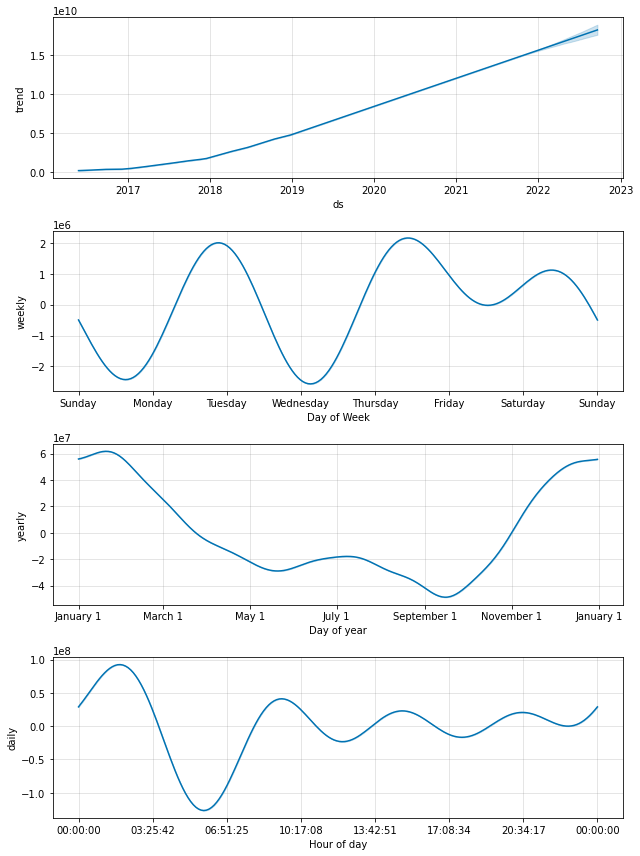

In [92]:
 md.plot_components(forecast)

In [102]:
y_yhat = top1_m.merge(forecast[["ds","yhat"]],left_on="Date",right_on="ds")
r2_score(y_yhat["TotalVideoViews"],y_yhat["yhat"])

0.9999453474916665

In [33]:
r2_score()

In [44]:
df1[(df1["Weekly Subscribers Gained"] == 100000)]

,Date,Weekly Subscribers Gained,Weekly Video Views Gained
53,2019-09-23,100000,52901676
54,2019-09-30,100000,38760077
56,2019-10-14,100000,49344701
57,2019-10-21,100000,49455309
58,2019-10-28,100000,48391676
...,...,...,...
144,2021-06-21,100000,59064810
146,2021-07-05,100000,56171040
148,2021-07-19,100000,51265550
151,2021-08-09,100000,55647911


# needs to check it 


In [ ]:
with open('req0.html') as page:
    html = page.read()
soup = BeautifulSoup(html, 'lxml')

In [ ]:
#print(soup.prettify())

In [ ]:
# up_string = soup.find_all(text=re.compile('Up'))
# up_string

In [ ]:
# rows = [row for row in soup.find_all("span",class_="YouTubeUserTopLight")]
# rows

In [ ]:
# soup.find_all("span",class_="YouTubeUserTopLight")[0].text

In [ ]:
# rows = [row for row in soup.find_all("span",style="font-weight: bold;")] 
# rows[0:6]

In [ ]:
list_columns=[]
for i in soup.find_all("span",class_="YouTubeUserTopLight"):
        list_columns.append(i.get_text())
print(list_columns)

In [ ]:
list_req0=[]
for i in soup.find_all("span",style="font-weight: bold;"):
        list_req0.append(i.get_text())
print(list_req0)